# LAB 01 - SMA
# ID: 21280047 
# Name: Tran Mai Chi Tam

### Load Data

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
import os
path = 'data'
os.listdir(path)

['know_voz_think.csv',
 'predictions.csv',
 'test.csv',
 'train.csv',
 'voz_complete_data.csv',
 'voz_complete_data_with_predictions.csv']

In [3]:
test_df = pd.read_csv(os.path.join(path, 'test.csv'))
train_df = pd.read_csv(os.path.join(path, 'train.csv'))
# fast look at data
print(test_df.head())
print(train_df.head())

   2                                           Great CD  \
0  2  One of the best game music soundtracks - for a...   
1  1                   Batteries died within a year ...   
2  2              works fine, but Maha Energy is better   
3  2                       Great for the non-audiophile   
4  1              DVD Player crapped out after one year   

  My lovely Pat has one of the GREAT voices of her generation. I have listened to this CD for YEARS and I still LOVE IT. When I'm in a good mood it makes me feel better. A bad mood just evaporates like sugar in the rain. This CD just oozes LIFE. Vocals are jusat STUUNNING and lyrics just kill. One of life's hidden gems. This is a desert isle CD in my book. Why she never made it big is just beyond me. Everytime I play this, no matter black, white, young, old, male, female EVERYBODY says one thing "Who was that singing ?"  
0  Despite the fact that I have only played a sma...                                                                 

In [4]:
# make correct column names
columns_name = ['polarity', 'title', 'text']
train_df.columns = columns_name
test_df.columns = columns_name


### EDA

In [5]:
# fast look at data
print("Train dataset info:")
print(train_df.info())
print("\nTest dataset info:")
print(test_df.info())



Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3599999 entries, 0 to 3599998
Data columns (total 3 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   polarity  int64 
 1   title     object
 2   text      object
dtypes: int64(1), object(2)
memory usage: 82.4+ MB
None

Test dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399999 entries, 0 to 399998
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   polarity  399999 non-null  int64 
 1   title     399975 non-null  object
 2   text      399999 non-null  object
dtypes: int64(1), object(2)
memory usage: 9.2+ MB
None


In [6]:
# check missing values
print("\nMissing values in train dataset:")
print(train_df.isnull().sum())
print("\nMissing values in test dataset:") 
print(test_df.isnull().sum())


Missing values in train dataset:
polarity      0
title       207
text          0
dtype: int64

Missing values in test dataset:
polarity     0
title       24
text         0
dtype: int64


In [7]:
# null data should be == "" 
train_df['title'] = train_df['title'].fillna("")
train_df['text'] = train_df['text'].fillna("")
test_df['title'] = test_df['title'].fillna("")
test_df['text'] = test_df['text'].fillna("")

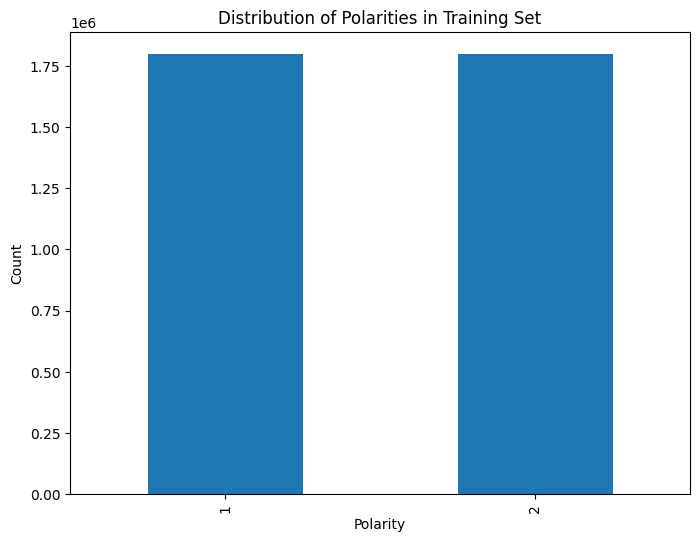

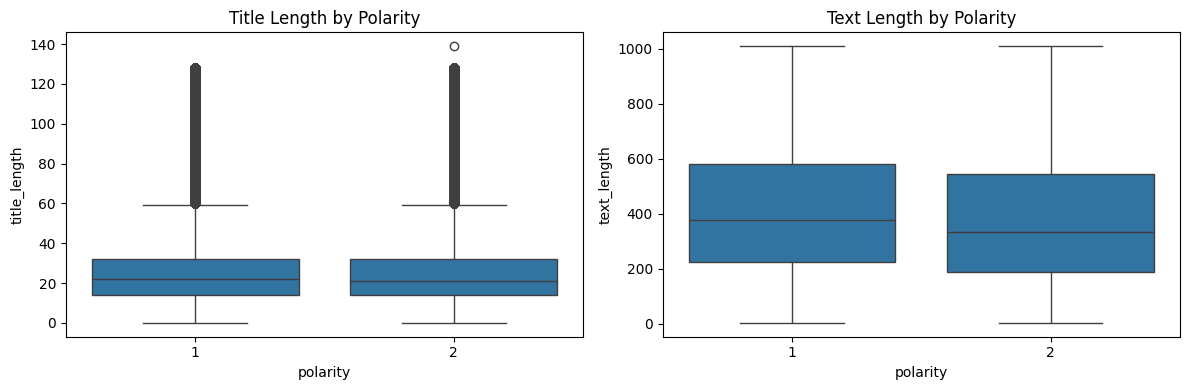


Summary statistics for text lengths:
       title_length   text_length
count  3.599999e+06  3.599999e+06
mean   2.450652e+01  4.051396e+02
std    1.401689e+01  2.342711e+02
min    0.000000e+00  4.000000e+00
25%    1.400000e+01  2.070000e+02
50%    2.100000e+01  3.560000e+02
75%    3.200000e+01  5.660000e+02
max    1.390000e+02  1.010000e+03


In [8]:
plt.figure(figsize=(8,6))
train_df['polarity'].value_counts().plot(kind='bar')
plt.title('Distribution of Polarities in Training Set')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.show()

train_df['title_length'] = train_df['title'].str.len()
train_df['text_length'] = train_df['text'].str.len()

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.boxplot(x='polarity', y='title_length', data=train_df)
plt.title('Title Length by Polarity')

plt.subplot(1,2,2)
sns.boxplot(x='polarity', y='text_length', data=train_df)
plt.title('Text Length by Polarity')
plt.tight_layout()
plt.show()

# Summary statistics
print("\nSummary statistics for text lengths:")
print(train_df[['title_length', 'text_length']].describe())

### Data Preprocessing, Preparation

#### Preprocessing

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [10]:
train_df['polarity'] = train_df['polarity'] - 1
train_df['polarity']

0          1
1          1
2          1
3          1
4          1
          ..
3599994    0
3599995    0
3599996    0
3599997    0
3599998    1
Name: polarity, Length: 3599999, dtype: int64

In [11]:
#apply it to test
test_df['polarity'] = test_df['polarity'] - 1

In [12]:
train_df['combined'] = train_df['title'] + ' ' + train_df['text']
test_df['combined'] = test_df['title'] + ' ' + test_df['text']

##### Get Vocab

In [13]:
class TextDataset(Dataset):
    def __init__(self, df, vocab):
        self.texts = df['combined'].tolist()
        self.labels = df['polarity'].tolist()
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = text.split()
        input_ids = torch.tensor([self.vocab.get(token) for token in tokens], dtype=torch.long)
        return {'input_ids': input_ids, 'label': torch.tensor(label, dtype=torch.long)}

In [14]:
class Vocabulary:
    def __init__(self):
        self.word2idx = {"<unk>": 0, "<pad>": 1}
        self.idx2word = ["<unk>", "<pad>"]

    def build_vocab(self, texts):
        for text in texts:
            for token in text.split():
                if token not in self.word2idx:
                    self.word2idx[token] = len(self.idx2word)
                    self.idx2word.append(token)

    def __len__(self):
        return len(self.idx2word)

    def get(self, token):
        return self.word2idx.get(token, self.word2idx["<unk>"])

In [15]:
class CollateFn:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        input_ids = [item['input_ids'] for item in batch]
        labels = torch.tensor([item['label'] for item in batch], dtype=torch.long)
        input_ids = nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=self.pad_idx)
        return {'input_ids': input_ids, 'labels': labels}

In [16]:

import pickle 

vocab = Vocabulary()
if os.path.exists('vocab.pkl'):
    with open('vocab.pkl', 'rb') as f:
        print('vocab loaded')
        vocab = pickle.load(f)
else:
    vocab.build_vocab(train_df['combined'])
    with open('vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)

vocab

vocab loaded


In [17]:
vocab.word2idx

{'<unk>': 0,
 '<pad>': 1,
 'The': 2,
 'best': 3,
 'soundtrack': 4,
 'ever': 5,
 'to': 6,
 'anything.': 7,
 "I'm": 8,
 'reading': 9,
 'a': 10,
 'lot': 11,
 'of': 12,
 'reviews': 13,
 'saying': 14,
 'that': 15,
 'this': 16,
 'is': 17,
 'the': 18,
 "'game": 19,
 "soundtrack'": 20,
 'and': 21,
 'I': 22,
 'figured': 23,
 "I'd": 24,
 'write': 25,
 'review': 26,
 'disagree': 27,
 'bit.': 28,
 'This': 29,
 'in': 30,
 'my': 31,
 'opinino': 32,
 'Yasunori': 33,
 "Mitsuda's": 34,
 'ultimate': 35,
 'masterpiece.': 36,
 'music': 37,
 'timeless': 38,
 'been': 39,
 'listening': 40,
 'it': 41,
 'for': 42,
 'years': 43,
 'now': 44,
 'its': 45,
 'beauty': 46,
 'simply': 47,
 'refuses': 48,
 'fade.The': 49,
 'price': 50,
 'tag': 51,
 'on': 52,
 'pretty': 53,
 'staggering': 54,
 'must': 55,
 'say,': 56,
 'but': 57,
 'if': 58,
 'you': 59,
 'are': 60,
 'going': 61,
 'buy': 62,
 'any': 63,
 'cd': 64,
 'much': 65,
 'money,': 66,
 'only': 67,
 'one': 68,
 'feel': 69,
 'would': 70,
 'be': 71,
 'worth': 72,
 'ev

In [18]:
### after get vocab, we can confidece resample train set
n_sample = 20000
train_df_resample = train_df.sample(n=n_sample, random_state=42).reset_index(drop=True)

train_df_resample, val_df = train_test_split(train_df_resample, test_size=0.2, random_state=42)
#Load Dataset
train_dataset = TextDataset(train_df_resample, vocab)
val_dataset = TextDataset(val_df, vocab)
test_dataset = TextDataset(test_df, vocab)
#Create Dataloader
collate_fn = CollateFn(pad_idx=vocab.word2idx["<pad>"])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

## Training Stage

### 1. RNN Model

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
# init rnn model
class RNNModel(nn.Module):
    '''
        RNN Model for text classification
        Args:
            vocab_size (int): Size of vocabulary
            embed_size (int): Size of word embeddings
            hidden_size (int): Number of hidden units in RNN
            output_size (int): Number of output classes
            num_layers (int): Number of RNN layers
            pad_idx (int): Index used for padding
            
        Forward pass:
            x: Input tensor of shape [batch_size, seq_length]
            Returns tensor of shape [batch_size, output_size]
    '''
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, num_layers, pad_idx):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx) #embedding stage
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        h0 = h0.to(x.device)
        
        embeds = self.embedding(x)
        out, _ = self.rnn(embeds, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class RNN_Trainer:
    '''
        Trainer class for training and evaluating PyTorch models
        Args:
            model (nn.Module): PyTorch model
            criterion (nn.Module): Loss function
            optimizer (torch.optim): Optimizer for training
            device (str): Device to run the model on (default: 'cuda' if available else 'cpu')
        Methods:
            validate: Evaluate the model on a validation set
            train: Train the model
            evaluate: Evaluate the model on a test set
    '''
    def __init__(self, model, criterion, optimizer, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def validate(self, val_loader):
        self.model.eval()
        total_loss, correct, total = 0, 0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)
                total_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(val_loader)
        accuracy = correct / total
        return avg_loss, accuracy

    def train(self, train_loader, val_loader=None, num_epochs=10):
        metrics = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            correct_train = 0
            total_train = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
            for batch in progress_bar:
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)

                # Backward pass
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                progress_bar.set_postfix(loss=loss.item())

            avg_train_loss = total_loss / len(train_loader)
            train_accuracy = correct_train / total_train

            metrics['epoch'].append(epoch + 1)
            metrics['train_loss'].append(avg_train_loss)
            metrics['train_accuracy'].append(train_accuracy)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}")

            if val_loader:
                val_loss, val_accuracy = self.validate(val_loader)
                metrics['val_loss'].append(val_loss)
                metrics['val_accuracy'].append(val_accuracy)
                print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")
            else:
                metrics['val_loss'].append(None)
                metrics['val_accuracy'].append(None)

        return metrics


    def evaluate(self, test_loader):
        self.model.eval()
        correct, total = 0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids)
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct / total
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(len(set(all_labels)))])

        print(f"Test Accuracy: {accuracy:.2%}")
        print("Confusion Matrix:")
        print(cm)
        print("Classification Report:")
        print(report)

        return accuracy, cm, report


In [ ]:
params = {
    'vocab_size': len(vocab),
    'embed_size': 64,
    'hidden_size': 128,
    'output_size': len(set(train_df['polarity'])),
    'num_layers': 1,
    'pad_idx': vocab.word2idx["<pad>"]
}

model = RNNModel(**params)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01) 

trainer = RNN_Trainer(model, criterion, optimizer)
metrics = trainer.train(train_loader, val_loader, num_epochs=10)

Epoch 1/10: 100%|██████████| 500/500 [00:21<00:00, 23.79it/s, loss=0.691]


Epoch [1/10], Training Loss: 0.6934, Training Accuracy: 49.84%
Epoch [1/10], Validation Loss: 0.6939, Accuracy: 48.65%


Epoch 2/10: 100%|██████████| 500/500 [00:22<00:00, 22.51it/s, loss=0.696]


Epoch [2/10], Training Loss: 0.6935, Training Accuracy: 49.43%
Epoch [2/10], Validation Loss: 0.6936, Accuracy: 51.10%


Epoch 3/10: 100%|██████████| 500/500 [00:22<00:00, 22.64it/s, loss=0.688]


Epoch [3/10], Training Loss: 0.6931, Training Accuracy: 49.55%
Epoch [3/10], Validation Loss: 0.6935, Accuracy: 51.05%


Epoch 4/10: 100%|██████████| 500/500 [00:22<00:00, 22.38it/s, loss=0.693]


Epoch [4/10], Training Loss: 0.6930, Training Accuracy: 49.75%
Epoch [4/10], Validation Loss: 0.6934, Accuracy: 51.28%


Epoch 5/10: 100%|██████████| 500/500 [00:22<00:00, 22.54it/s, loss=0.686]


Epoch [5/10], Training Loss: 0.6931, Training Accuracy: 49.92%
Epoch [5/10], Validation Loss: 0.6936, Accuracy: 48.62%


Epoch 6/10: 100%|██████████| 500/500 [00:22<00:00, 22.55it/s, loss=0.698]


Epoch [6/10], Training Loss: 0.6930, Training Accuracy: 50.20%
Epoch [6/10], Validation Loss: 0.6936, Accuracy: 51.05%


Epoch 7/10: 100%|██████████| 500/500 [00:21<00:00, 22.95it/s, loss=0.703]


Epoch [7/10], Training Loss: 0.6926, Training Accuracy: 50.26%
Epoch [7/10], Validation Loss: 0.6941, Accuracy: 48.52%


Epoch 8/10: 100%|██████████| 500/500 [00:21<00:00, 22.91it/s, loss=0.706]


Epoch [8/10], Training Loss: 0.6926, Training Accuracy: 50.49%
Epoch [8/10], Validation Loss: 0.6944, Accuracy: 48.60%


Epoch 9/10: 100%|██████████| 500/500 [00:21<00:00, 22.78it/s, loss=0.687]


Epoch [9/10], Training Loss: 0.6923, Training Accuracy: 50.54%
Epoch [9/10], Validation Loss: 0.6936, Accuracy: 51.08%


Epoch 10/10: 100%|██████████| 500/500 [00:21<00:00, 22.95it/s, loss=0.689]


Epoch [10/10], Training Loss: 0.6924, Training Accuracy: 50.45%
Epoch [10/10], Validation Loss: 0.6944, Accuracy: 48.55%


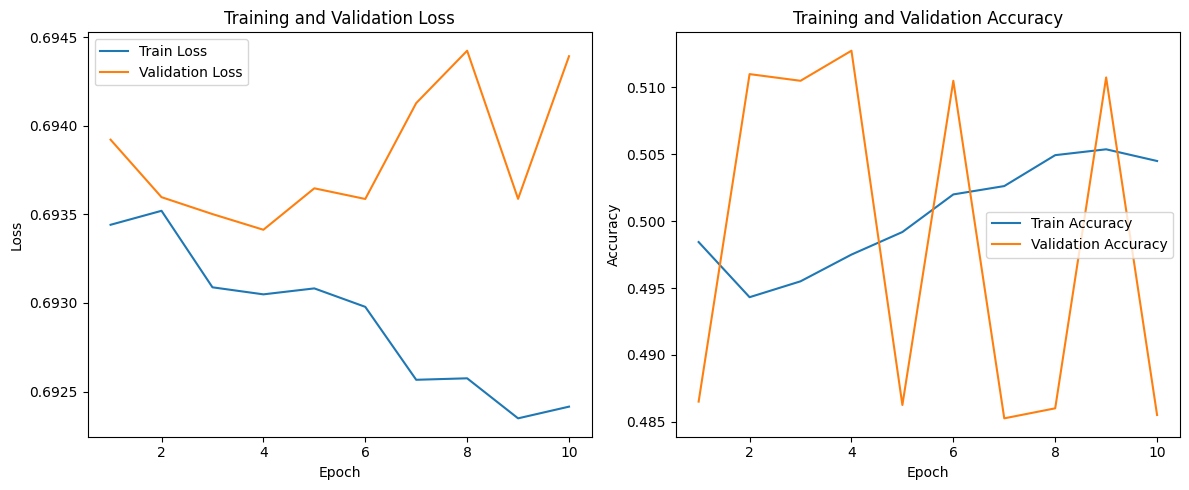

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(metrics['epoch'], metrics['train_loss'], label='Train Loss')
plt.plot(metrics['epoch'], metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(metrics['epoch'], metrics['train_accuracy'], label='Train Accuracy')
plt.plot(metrics['epoch'], metrics['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_accuracy, cm, report = trainer.evaluate(test_loader)

Test Accuracy: 49.94%
Confusion Matrix:
[[197355   2645]
 [197588   2411]]
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.99      0.66    200000
           1       0.48      0.01      0.02    199999

    accuracy                           0.50    399999
   macro avg       0.49      0.50      0.34    399999
weighted avg       0.49      0.50      0.34    399999



maybe data train so small, so we can't get good result. Lets start with another method, before we go we will train model with word2vec and tokenizer 

### 2. Transformer model

In [34]:
#free memory
del model
del criterion
del optimizer

In [33]:
import gc

# Call garbage collector
gc.collect()

# Clear CUDA cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

#### Transformer Init

In [34]:
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, num_heads, num_layers, hidden_dim, max_len=512):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, max_len, embed_size))
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embed_size, num_heads, hidden_dim), num_layers
        )
        self.fc = nn.Linear(embed_size, num_classes)
    
    def forward(self, x):
        x = self.embedding(x) + self.positional_encoding[:, :x.size(1)]
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x[-1, :, :]
        x = self.fc(x)
        return x

#### Training

In [35]:
class Transformer_Trainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model.to(device)  # Ensure the model is on the correct device
        self.criterion = criterion.to(device)  # Ensure loss function is on the correct device
        self.optimizer = optimizer
        self.device = device

    def validate(self, val_loader):
        self.model.eval()  # Set model to evaluation mode
        total_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # Disable gradient computation for validation
            for batch in val_loader:
                input_ids = batch['input_ids'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)

                total_loss += loss.item()

                # Calculate validation accuracy
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        return avg_val_loss, val_accuracy


    def train(self, train_loader, val_loader=None, num_epochs=10):
        metrics = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

        for epoch in range(num_epochs):
            self.model.train()
            total_loss = 0
            correct_train = 0
            total_train = 0
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

            for batch in progress_bar:
                input_ids = batch['input_ids'].to(self.device)  # Move data to correct device
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.model(input_ids)
                loss = self.criterion(outputs, labels)

                # Backward pass
                self.optimizer.zero_grad()  # Clear previous gradients
                loss.backward()  # Backpropagate the gradients
                self.optimizer.step()  # Update model parameters

                total_loss += loss.item()

                # Calculate training accuracy
                _, predicted = torch.max(outputs, 1)
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

                progress_bar.set_postfix(loss=loss.item())

            avg_train_loss = total_loss / len(train_loader)
            train_accuracy = correct_train / total_train

            metrics['epoch'].append(epoch + 1)
            metrics['train_loss'].append(avg_train_loss)
            metrics['train_accuracy'].append(train_accuracy)
            print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2%}")

            if val_loader:
                val_loss, val_accuracy = self.validate(val_loader)
                metrics['val_loss'].append(val_loss)
                metrics['val_accuracy'].append(val_accuracy)
                print(f"Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")
            else:
                metrics['val_loss'].append(None)
                metrics['val_accuracy'].append(None)

        return metrics

    def evaluate(self, test_loader):
        self.model.eval()  # Set model to evaluation mode
        correct, total = 0, 0
        all_preds = []
        all_labels = []

        with torch.no_grad():  # Disable gradient computation during testing
            for batch in test_loader:
                input_ids = batch['input_ids'].to(self.device)  # Move data to device
                labels = batch['labels'].to(self.device)

                # Forward pass
                outputs = self.model(input_ids)

                # Get predicted classes
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Store predictions and labels for confusion matrix
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate accuracy
        accuracy = correct / total
        # Generate confusion matrix and classification report
        cm = confusion_matrix(all_labels, all_preds)
        report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(len(set(all_labels)))])

        # Print metrics
        print(f"Test Accuracy: {accuracy:.2%}")
        print("Confusion Matrix:")
        print(cm)
        print("Classification Report:")
        print(report)

        # Return metrics
        return accuracy, cm, report

In [36]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'lr': [0.001, 0.01],
    'num_layers': [2, 6],
    'embed_size': [64, 128],
    'num_heads': [2, 4],
}

grid = ParameterGrid(param_grid)


In [37]:
len(grid)

16

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
best_val_accuracy = 0
best_params = None
criterion = nn.CrossEntropyLoss()
for params in grid:
    model = TransformerClassifier(
        len(vocab), 
        embed_size=params['embed_size'], 
        num_classes=len(set(train_df['polarity'])), 
        num_heads= params['num_heads'],
        num_layers=params['num_layers'], 
        hidden_dim=128
    ).to(device)
    optimizer = optim.SGD(model.parameters(), lr=params['lr'])
    trainer = Transformer_Trainer(model, criterion, optimizer, device)
    metrics = trainer.train(train_loader, val_loader, num_epochs=5)
    
    val_accuracy = metrics['val_accuracy'][-1]
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_params = params
    del model
    torch.cuda.empty_cache()


print("Best Parameters:", best_params)


d:\Programs\miniconda\envs\sma\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/5: 100%|██████████| 500/500 [00:27<00:00, 18.28it/s, loss=0.699]


Epoch [1/5], Training Loss: 0.7109, Training Accuracy: 50.49%
Epoch [1/5], Validation Loss: 0.7020, Accuracy: 51.35%


Epoch 2/5: 100%|██████████| 500/500 [00:27<00:00, 17.96it/s, loss=0.688]


Epoch [2/5], Training Loss: 0.7046, Training Accuracy: 50.76%
Epoch [2/5], Validation Loss: 0.6988, Accuracy: 51.35%


Epoch 3/5: 100%|██████████| 500/500 [00:28<00:00, 17.43it/s, loss=0.719]


Epoch [3/5], Training Loss: 0.7014, Training Accuracy: 50.54%
Epoch [3/5], Validation Loss: 0.6969, Accuracy: 51.38%


Epoch 4/5: 100%|██████████| 500/500 [00:29<00:00, 17.18it/s, loss=0.677]


Epoch [4/5], Training Loss: 0.6990, Training Accuracy: 51.11%
Epoch [4/5], Validation Loss: 0.6959, Accuracy: 51.45%


Epoch 5/5: 100%|██████████| 500/500 [00:29<00:00, 17.14it/s, loss=0.738]


Epoch [5/5], Training Loss: 0.6969, Training Accuracy: 51.61%
Epoch [5/5], Validation Loss: 0.6953, Accuracy: 51.75%


d:\Programs\miniconda\envs\sma\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/5: 100%|██████████| 500/500 [01:08<00:00,  7.31it/s, loss=0.689]


Epoch [1/5], Training Loss: 0.7022, Training Accuracy: 50.19%
Epoch [1/5], Validation Loss: 0.6930, Accuracy: 51.78%


Epoch 2/5: 100%|██████████| 500/500 [01:08<00:00,  7.26it/s, loss=0.72] 


Epoch [2/5], Training Loss: 0.6965, Training Accuracy: 50.86%
Epoch [2/5], Validation Loss: 0.6911, Accuracy: 52.35%


Epoch 3/5: 100%|██████████| 500/500 [01:02<00:00,  8.01it/s, loss=0.671]


Epoch [3/5], Training Loss: 0.6932, Training Accuracy: 52.80%
Epoch [3/5], Validation Loss: 0.6906, Accuracy: 53.08%


Epoch 4/5: 100%|██████████| 500/500 [01:06<00:00,  7.52it/s, loss=0.707]


Epoch [4/5], Training Loss: 0.6927, Training Accuracy: 52.58%
Epoch [4/5], Validation Loss: 0.6920, Accuracy: 53.25%


Epoch 5/5: 100%|██████████| 500/500 [01:08<00:00,  7.29it/s, loss=0.676]


Epoch [5/5], Training Loss: 0.6918, Training Accuracy: 52.88%
Epoch [5/5], Validation Loss: 0.6899, Accuracy: 52.68%


Epoch 1/5: 100%|██████████| 500/500 [00:33<00:00, 14.92it/s, loss=0.685]


Epoch [1/5], Training Loss: 0.7210, Training Accuracy: 50.49%
Epoch [1/5], Validation Loss: 0.7144, Accuracy: 50.05%


Epoch 2/5: 100%|██████████| 500/500 [00:31<00:00, 15.70it/s, loss=0.69] 


Epoch [2/5], Training Loss: 0.7057, Training Accuracy: 51.02%
Epoch [2/5], Validation Loss: 0.7070, Accuracy: 50.18%


Epoch 3/5: 100%|██████████| 500/500 [00:31<00:00, 15.83it/s, loss=0.706]


Epoch [3/5], Training Loss: 0.7010, Training Accuracy: 50.84%
Epoch [3/5], Validation Loss: 0.7039, Accuracy: 50.80%


Epoch 4/5: 100%|██████████| 500/500 [00:31<00:00, 16.12it/s, loss=0.722]


Epoch [4/5], Training Loss: 0.7000, Training Accuracy: 51.55%
Epoch [4/5], Validation Loss: 0.7008, Accuracy: 51.10%


Epoch 5/5: 100%|██████████| 500/500 [00:30<00:00, 16.20it/s, loss=0.675]


Epoch [5/5], Training Loss: 0.6955, Training Accuracy: 52.82%
Epoch [5/5], Validation Loss: 0.6997, Accuracy: 51.10%


Epoch 1/5: 100%|██████████| 500/500 [02:50<00:00,  2.93it/s, loss=0.702]


Epoch [1/5], Training Loss: 0.7001, Training Accuracy: 50.30%
Epoch [1/5], Validation Loss: 0.6961, Accuracy: 51.55%


Epoch 2/5: 100%|██████████| 500/500 [02:30<00:00,  3.32it/s, loss=0.689]


Epoch [2/5], Training Loss: 0.6959, Training Accuracy: 50.98%
Epoch [2/5], Validation Loss: 0.6941, Accuracy: 50.85%


Epoch 3/5: 100%|██████████| 500/500 [02:19<00:00,  3.58it/s, loss=0.728]


Epoch [3/5], Training Loss: 0.6948, Training Accuracy: 52.12%
Epoch [3/5], Validation Loss: 0.6939, Accuracy: 51.95%


Epoch 4/5: 100%|██████████| 500/500 [02:20<00:00,  3.57it/s, loss=0.698]


Epoch [4/5], Training Loss: 0.6936, Training Accuracy: 52.30%
Epoch [4/5], Validation Loss: 0.6947, Accuracy: 52.30%


Epoch 5/5:   3%|▎         | 17/500 [00:05<02:21,  3.42it/s, loss=0.719]

In [ ]:
vocab_size = len(vocab)
embed_size = 64
num_classes = len(set(train_df['polarity']))
num_heads = 8
num_layers = 4
hidden_dim = 128
model = TransformerClassifier(vocab_size, embed_size, num_classes, num_heads, num_layers, hidden_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=.001)
trainer = Transformer_Trainer(model, criterion, optimizer, device)
metrics = trainer.train(train_loader, val_loader, num_epochs=10)

d:\Programs\miniconda\envs\sma\lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Epoch 1/10:   4%|▍         | 22/500 [00:17<05:59,  1.33it/s, loss=0.853]

Epoch 1/10:   0%|          | 0/500 [00:00<?, ?it/s]


TypeError: 'SGD' object is not callable